In [2]:
import networkx as nx
# import powerlaw as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from collections import Counter 
from networkx.algorithms.community.quality import modularity
import EoN

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
G = nx.read_edgelist('LFM1.csv', delimiter=',')

In [4]:
print(G)
# G.in_degree()

Graph with 7624 nodes and 27806 edges


Now we are going to do community discovery. We are going to use networkx module **community**.

In [5]:
# Run Label Propagation algorithm
# import community
# communities_lp = nx.algorithms.community.label_propagation.label_propagation_communities(G)
communities_louvain = nx.algorithms.community.louvain_communities(G)
# communities_greedy_mod = nx.algorithms.community.greedy_modularity_communities(G)

# Convert communities to a list for better visualization
# communities_list_lp = [list(community) for community in communities_lp]
communities_list_louvain = [list(community) for community in communities_louvain]
# communities_list_gm = [list(community) for community in communities_greedy_mod]

# Print the detected communities
# print("Detected Communities:")
# for i, community in enumerate(communities_list):
#     print(f"Community {i + 1}: {community}")


In [9]:
# print(len(communities_list_lp))
print(len(communities_list_louvain))
# print(len(communities_list_gm))

# modularity_lp = modularity(G, communities_list_lp)
modularity_louvain = modularity(G, communities_list_louvain) #the chosen one
# modularity_gm = modularity(G, communities_list_gm)
# print(modularity_lp)
print(modularity_louvain)
# print(modularity_gm)
#print modularity

30
0.8133229241406776


In [10]:
lengths_com = [(len(c)/7624)*100 for c in communities_list_louvain]
# lengths_com = [len(c) for c in communities_list_louvain]
print(sorted(lengths_com, reverse=True)[:14])

[19.858342077649528, 13.208289611752361, 13.19517313746065, 12.316369359916054, 8.053515215110178, 6.571353620146904, 6.243441762854145, 3.6726128016789086, 2.911857292759706, 2.0724029380902413, 1.8756558237145855, 1.8100734522560336, 1.6657922350472192, 1.4165792235047219]


In [11]:
min([len(c) for c in communities_list_louvain])

4

We chose louvain communities algorithm, because it gives highest modularity and a stable number of communities (read more about it). 

We saw there are some communities on the bottom that only contain 5-4 nodes, so we will ignore them (why? - think of good reason). 

So we take the top 16 communities, each containing more than 1% of the nodes in the network.

From those we choose the biggest, smallest and middle one and see how the contagion spreads when we infect the nodes in them with highes degree/betweenness centrality. That should give us 3 different models. For each of them we will try several combinations of infection and recovery rate.

We want to also see a random case in which we randomly choose a node/3 nodes from the network, regardless of community.

OUR RESEARCH QUESTION: **Is the speed of the spread influenced by the size of the community associated with the initial node?**

In [36]:
#limitation: not 100% likely that people will be in a single disjoint community; in future we are going to extend this to overlapping communities.

In [16]:
between_centr = nx.betweenness_centrality(G)

In [18]:
#enumerating the communities
communities = dict()
com_size = dict()
for i in range(len(communities_list_louvain)):
    communities[i]=communities_list_louvain[i]
    com_size[i] = len(communities_list_louvain[i])

In [295]:
#the communities sorted in descending order by size
communities_sorted_desc = sorted(communities, key=lambda k: len(communities[k]), reverse=True)
communities_sorted_desc

[12,
 9,
 13,
 28,
 1,
 19,
 15,
 4,
 17,
 8,
 11,
 21,
 3,
 5,
 7,
 23,
 0,
 10,
 18,
 16,
 27,
 2,
 22,
 24,
 14,
 25,
 26,
 6,
 20,
 29]

In [20]:
def find_betw(com_id, communities=communities):
    '''Function returns the node with largest betweennes centrality from a given community'''
    community = communities[com_id]
    lis = [between_centr[node] for node in community]
    value = [i for i in between_centr if between_centr[i]==max(lis)]
    return int(value[0])

In [296]:
#community #27 is the smallest one from those with >1% nodes, its size is 72
node_l_bc = find_betw(communities_sorted_desc[12], communities=communities)
node_l_bc

4356

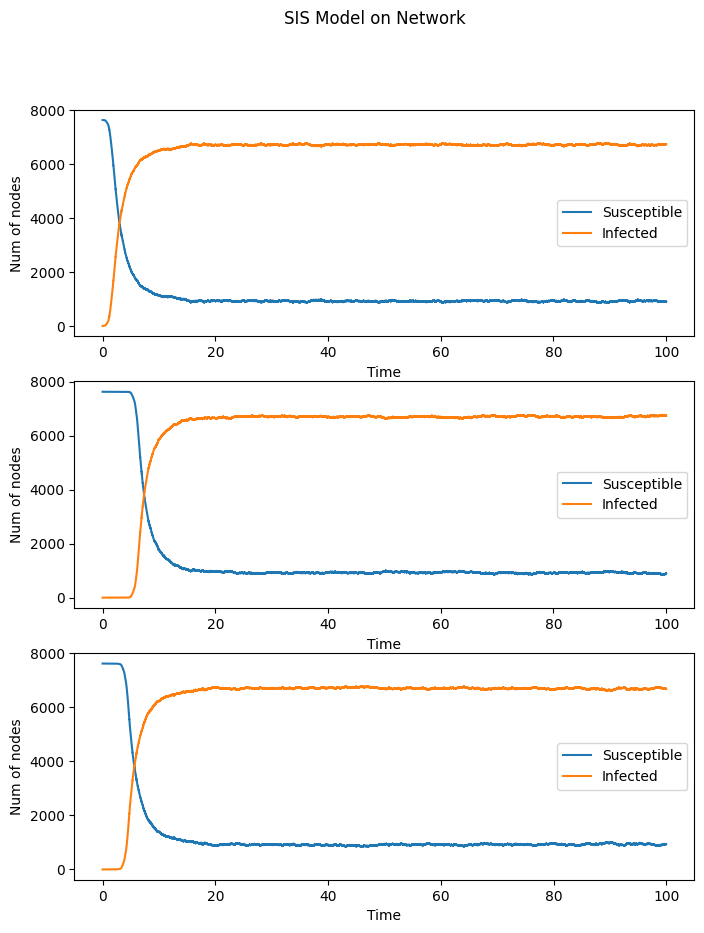

In [328]:
# Parameters
beta = 0.3  # transmission rate
gamma = 0.1  # recovery rate
initial_infected1 = [7237]
initial_infected2 = [3571]
initial_infected3 = [5851] # starting point
G = nx.convert_node_labels_to_integers(G, first_label=0)
 
# Run the SIR model on the network
sim1 = EoN.fast_SIS(G, beta, gamma, initial_infecteds=initial_infected1, return_full_data=True)
sim2 = EoN.fast_SIS(G, beta, gamma, initial_infecteds=initial_infected2, return_full_data=True)
sim3 = EoN.fast_SIS(G, beta, gamma, initial_infecteds=initial_infected3, return_full_data=True)
 
# Access the data from the Simulation_Investigation object
t1, S1, I1 = sim1.t(), sim1.S(), sim1.I()
t2, S2, I2 = sim2.t(), sim2.S(), sim2.I()
t3, S3, I3 = sim3.t(), sim3.S(), sim3.I()
 
# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
fig.suptitle('SIS Model on Network')

ax1.plot(t1, S1, label='Susceptible')
ax1.plot(t1, I1, label='Infected')

ax2.plot(t2, S2, label='Susceptible')
ax2.plot(t2, I2, label='Infected')

ax3.plot(t3, S3, label='Susceptible')
ax3.plot(t3, I3, label='Infected')

ax1.set(xlabel='Time', ylabel='Num of nodes')
ax1.legend()

ax2.set(xlabel='Time', ylabel='Num of nodes')
ax2.legend()

ax3.set(xlabel='Time', ylabel='Num of nodes')
ax3.legend()


# plt.plot(t, S, label='Susceptible')
# plt.plot(t, I, label='Infected')
# # plt.plot(t, R, label='Recovered')
# plt.xlabel('Time')
# plt.ylabel('Number of nodes')
# plt.title('SIR Model on Network trans>recovery')
# plt.legend()
# plt.show()

# recovered = 0
# for i in range(len(list(G.nodes()))):
#     if full_data[i] == 'R':
#         recovered +=1
# print("Percentage of recovered in the end: ", recovered/(len(list(G.nodes()))))
# print("Max steps to stabilize: ", np.round(max(t)))
# print("Max Infected at a given time: ", max(I), np.round(t[I[(max(I))]]))

In [310]:
#for inf_r = 0.2 and r_rate = 0.15 in 33% of the cases the desease dies in 1st step

In [309]:
# # Parameters
# beta = 0.3  # transmission rate
# gamma = 0.1  # recovery rate
# initial_infected = [4356]  # starting point
# G = nx.convert_node_labels_to_integers(G, first_label=0)
 
# # Run the SIR model on the network
# sim = EoN.fast_SI(G, beta, gamma, initial_infecteds=initial_infected, return_full_data=True)
 
# # Access the data from the Simulation_Investigation object
# t, S, I, R, full_data = sim.t(), sim.S(), sim.I(), sim.R(), sim.get_statuses(nodelist=list(G.nodes()), time=60)
 
# # Plot the results
# plt.plot(t, S, label='Susceptible')
# plt.plot(t, I, label='Infected')
# plt.plot(t, R, label='Recovered')
# plt.xlabel('Time')
# plt.ylabel('Number of nodes')
# plt.title('SIR Model on Network trans>recovery')
# plt.legend()
# plt.show()

# recovered = 0
# for i in range(len(list(G.nodes()))):
#     if full_data[i] == 'R':
#         recovered +=1
# print("Percentage of recovered in the end: ", recovered/(len(list(G.nodes()))))
# print("Max steps to stabilize: ", np.round(max(t)))
# print("Max Infected at a given time: ", max(I), np.round(t[I[(max(I))]]))

1